<H1> NLP Final Project - Text Analysis of Reddit Comments
<H2> Alexander Mead & Wei-Hua Hsu
<H2> 2020/4/23

# `Setting up`
## Change work directory

In [1]:
import os
os.chdir("/Users/WaferHsu/Desktop/AU/2020Spring/STAT-696-NLP/FinalProj_Alex_Wafer")

## Import packages

In [2]:
# nltk
import nltk
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

# numpy
import numpy as np

# regex
import re

# pandas df
import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# used to remove Pandas warnings
import warnings
warnings.filterwarnings('ignore')

# sentiment analysis (vader)
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# normalize data
from sklearn.preprocessing import MinMaxScaler

# train/test split
from sklearn.model_selection import train_test_split

# Regression
import statsmodels.formula.api as sm
from sklearn import linear_model

# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# NMF (topic modeling)
from sklearn.decomposition import NMF

# KMeans Clustering
from sklearn.cluster import KMeans

# classifying modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier

# sklearn (classification)
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Visualizing Clusters
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS


## Load original dataset

In [3]:
data = pd.read_csv("./data/kaggle_RC_2019-05.csv", encoding = "utf8")

- Take a brief look at the data.

In [4]:
data.head(3)

,subreddit,body,controversiality,score
0,gameofthrones,Your submission has been automatically removed...,0,1
1,aww,"Dont squeeze her with you massive hand, you me...",0,19
2,gaming,It's pretty well known and it was a paid produ...,0,3


- Check missing values: Fortunately, we do not need to deal with NA values data.

In [5]:
data.isna().describe()

,subreddit,body,controversiality,score
count,1000000,1000000,1000000,1000000
unique,1,1,1,1
top,False,False,False,False
freq,1000000,1000000,1000000,1000000


- Check the "body" variable is a string variable.

In [6]:
data.dtypes

subreddit           object
body                object
controversiality     int64
score                int64
dtype: object

In [7]:
type(data["body"][0])

str

# `Exploratory Data Analysis (EDA)`

- Descriptive statistics for continuous variables. The maximum and minimum has a hugh difference.

In [43]:
data.describe()

,controversiality,score
count,1000000.000000,1000000.000000
mean,0.029583,11.510103
std,0.169434,149.671560
min,0.000000,-889.000000
25%,0.000000,1.000000
50%,0.000000,2.000000
75%,0.000000,4.000000
max,1.000000,35619.000000


## Controversiality
<br>

- The distribution of controversiality. It is heavily discrete distributed. There are so many less data in controversiality = 1.

Text(0.5, 0, 'Controversiality')

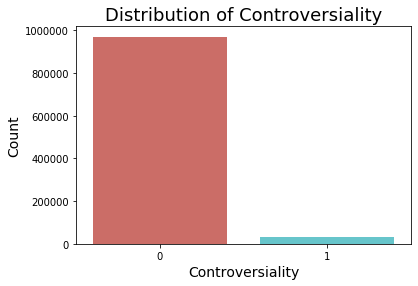

In [24]:
plt.figure(figsize = (6, 4))
sns.countplot(data.controversiality, palette = "hls")
plt.title("Distribution of Controversiality", fontsize = 18)
plt.ylabel("Count", fontsize = 14)
plt.xlabel("Controversiality", fontsize = 14)

- The frequency of controversiality.

In [12]:
print(data.controversiality.value_counts())

0    970417
1     29583
Name: controversiality, dtype: int64


## Score
<br>
Reddits scores (up reddits minus down reddits) are heavily skewed right. Data mainly distributed lower than 3000, and there are a lot of outliers.

Text(0.5, 0, 'Score')

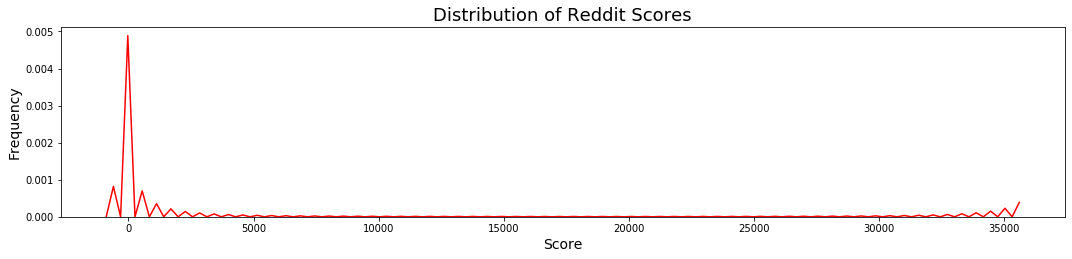

In [36]:
plt.figure(figsize = (18, 3.5))
sns.distplot(data.score, hist = False, color = "red", bins = 10)
plt.title("Distribution of Reddit Scores", fontsize = 18)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Score", fontsize = 14)

Text(0.5, 0, 'Reddits Reviews (from 0 to 1000000)')

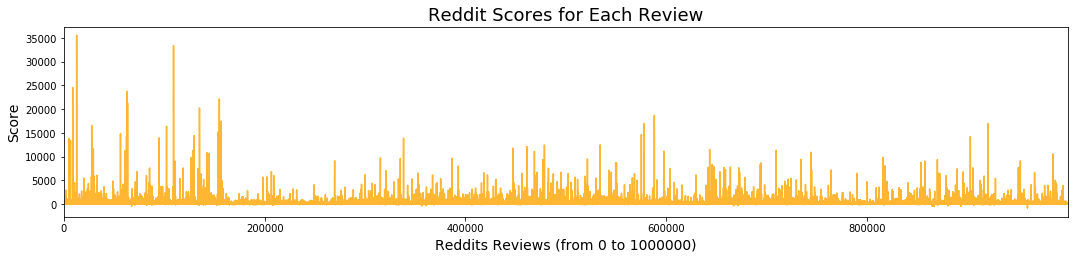

In [41]:
plt.figure(figsize = (18, 3.5))
data.score.plot(color = 'orange', alpha = 0.8)
plt.title("Reddit Scores for Each Review", fontsize = 18)
plt.ylabel("Score", fontsize = 14)
plt.xlabel("Reddits Reviews (from 0 to 1000000)", fontsize = 14)

## Subreddit
<br>

Frequency Counts of the column “subreddit”. Each category has 25000 reviews. Based on the subreddits, we could sort them out to some broader topics like "sports", "news & politics", "movies", "slangs", "online games/video games", and see the classification between two (or more) similar groups.
<br>
After filtering similar topics out, we are looking at the body text for sentiment analysis, topic modeling, and clustering to see if there is anything interesting results within the data. This project will focus on the category of politics.

In [44]:
data["subreddit"].value_counts()

The_Donald             25000
gonewild               25000
Market76               25000
worldnews              25000
ChapoTrapHouse         25000
apexlegends            25000
marvelstudios          25000
Animemes               25000
RoastMe                25000
soccer                 25000
unpopularopinion       25000
nfl                    25000
todayilearned          25000
Pikabu                 25000
gaming                 25000
funny                  25000
videos                 25000
leagueoflegends        25000
dankmemes              25000
teenagers              25000
gameofthrones          25000
wallstreetbets         25000
asoiaf                 25000
hockey                 25000
MortalKombat           25000
memes                  25000
freefolk               25000
relationship_advice    25000
trashy                 25000
politics               25000
movies                 25000
FortNiteBR             25000
pics                   25000
AskReddit              25000
aww           

# `Subset politics data by subreddit and the exploration`

In [46]:
politics_data = data[data["subreddit"] == "politics"]

In [47]:
politics_data = politics_data.reset_index(drop = True) # reset index

In [48]:
politics_data.head()

,subreddit,body,controversiality,score
0,politics,"Yes, there is a difference between gentle supp...",0,1
1,politics,"He also got married, and they filed jointly fo...",0,12
2,politics,So you think we can just tell people they no l...,0,1
3,politics,"ITT, lots of people without jobs complaining.",0,-6
4,politics,"""You boys wanna shovel some coal?""",0,17


## Distribution of Subreddit

Re-formatted histogram of politics subreddit scores with x-axis limits from (-50, 50) and y-axis limits from (0, 2000).

CPU times: user 2.67 s, sys: 111 ms, total: 2.78 s
Wall time: 2.79 s


(0, 2000)

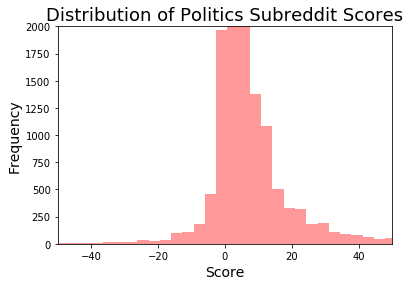

In [50]:
%%time
sns.distplot(politics_data["score"], kde = False, color = "red", bins = 3000)
plt.title("Distribution of Politics Subreddit Scores", fontsize = 18)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Score", fontsize = 14)
plt.xlim(-50,50)
plt.ylim(0, 2000)
# most scores fall within 0 to 20 and there are a lot more observations between 0 and 20 than 2000

## Creation of New body_length Variable
<br>
Counting number of characters in (uncleaned) body variable.

In [63]:
politics_data["body_length"] = [len(el) for el in politics_data["body"]]

In [64]:
politics_data.head()

,subreddit,body,controversiality,score,body_length
0,politics,"Yes, there is a difference between gentle supp...",0,1,101
1,politics,"He also got married, and they filed jointly fo...",0,12,145
2,politics,So you think we can just tell people they no l...,0,1,89
3,politics,"ITT, lots of people without jobs complaining.",0,-6,45
4,politics,"""You boys wanna shovel some coal?""",0,17,34


## Distribution of body_length (Histogram)
<br>
Data visualizing the body_length variable to see the data pattern. The body length is skewed to the right.

(0, 500)

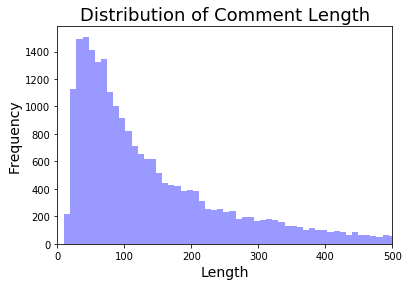

In [62]:
sns.distplot(politics_data.body_length, kde = False, color = "blue", bins = 1000)
plt.title("Distribution of Comment Length", fontsize = 18)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Length", fontsize = 14)
plt.xlim(0, 500)

## Summary statistics on continuous variables
<br>
The maximum in `score` is 9715 but the mean is 13, data is strongly discreated. Same situation in `body_length`, which maximun is 9156 but its mean is 212.

In [60]:
politics_data.describe()

,controversiality,score,body_length
count,25000.00000,25000.000000,25000.000000
mean,0.03224,13.809040,212.050040
std,0.17664,141.260591,298.831188
min,0.00000,-383.000000,10.000000
25%,0.00000,1.000000,59.000000
50%,0.00000,2.000000,113.000000
75%,0.00000,6.000000,242.000000
max,1.00000,9715.000000,9156.000000


# `Pre-processing politics_data`
## Spelling error checking
<br>
Test abbreviations or spelling errors. To be honest, there are a lot of things to do to fix the spelling error, my code below is incompleted, but this methodology helps me to understand how much more things I need to consider in the future data analysis.
<br>

**Reference:** https://medium.com/@indreshbhattacharyya/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff

- Test abbreviations: "wd", "bt", "der", "hs", "dt", "nt". According to the output, 'hs' = spelling error; 'dt' = (probably) doubt; 'nt' = not.

In [65]:
abbre_list = ["wd", "bt", "der", "hs", "dt", "nt"]


# make a list by "macthlist", find macches from the "politics_data"
matchlist_test = [" " + abbre_list[i] + " " for i in range(len(abbre_list))]
print("Add space before and after in order to test the word in reddits", matchlist_test)
print()

# print all matches by the "politics_data"
print("Matching reddits: ")
print()
for abbr in matchlist_test:
    for rv in politics_data["body"]:
        if abbr in rv:
            print("-----"+abbr+"-----")
            print(rv)
            print()

Add space before and after in order to test the word in reddits [' wd ', ' bt ', ' der ', ' hs ', ' dt ', ' nt ']

Matching reddits: 

----- hs -----
I think my favourite moment is the one where cartman pretends his hand is a conman pretending to be Jennifer lopez. The moment Kyle decides to believe him and he goes Ha ha hs ha ha ha, I got you kinda

----- dt -----
I'm not going to hold my breath. I just listened to Grassley on C-span and they're entrenched into the myth that barr/mueller exonerated dt - and they're continuing to spread that myth/propaganda widely.  Today's hearing with barr will be fascinating!
https://www.youtube.com/watch?v=CK2GNiXdE3c

----- nt -----
Didnt not nt mean it.



## Text Clean, Tokenize, and Lemmatization
<br>

- Write functions to clean and lemmatize "body" variable.

In [67]:
### text cleaning
def textCleaner(text):
    output = text
    
    #lowercase
    output = output.lower()
    
    # fix contractions
    output = output.replace("’", "'")
    output = output.replace("can't", "can not")
    output = output.replace("won't", "will not")
    output = output.replace("n't", " not")
    output = output.replace("\'ll", " will")
    output = output.replace("\'ve", " have")
    output = output.replace("\'d", " would")
    output = output.replace("\'s", " is") 
    output = output.replace("\'m", " am")
    output = output.replace("\'re", " are")
    
    # remove stop words
    clean_sentence = []
    for word in output.split():
        if word not in stopWords:
            clean_sentence.append(word)
    output = " ".join(clean_sentence)
        
    # remove email addresses & Internet domains
    output = re.sub(r'r\/\S+', '', output)
    output = re.sub(r'http\S+', '', output)
    output = re.sub("\S*@\S*\s?", "", output)
    output = re.sub("\S*\.edu|\.com|\.gov|\.net\S*\s?", "", output)
    output = re.sub("@\S*", "", output)
    
    # remove punctuations
    output = re.sub("[^a-zA-Z\s]", "", output)
    
    return(output)


### tokenize & lemmatiztion
def textNormalization(corpus):
    output = corpus

    # in the text, lemmatize each word in the tokenized list
    output = [lemmatizer.lemmatize(w) for w in word_tokenize(output)] 

    # rejoin all the words into one string by a space
    output = " ".join(output)
    
    return(output)

- Apply functions to the `body` variable.

In [82]:
politics_data["body"] = politics_data["body"].apply(textCleaner)
politics_data["body"] = politics_data["body"].apply(textNormalization)

# briefly print the variable
politics_data["body"].head()

0    yes difference gentle suppression hard suppres...
1    also got married filed jointly husband income ...
2               think tell people longer right express
3               itt lot people without job complaining
4                               boy wan na shovel coal
Name: body, dtype: object

## Distribution of *cleaned* body_length (Histogram)
<br>

- Change `body_length` from characters to number of words.

In [74]:
politics_data["body_length"] = [len(el.split()) for el in politics_data["body"]]

- The distribution of the `body_length` variable.

(0, 80)

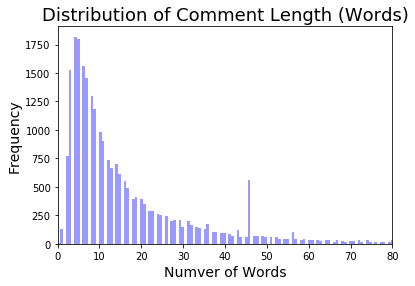

In [79]:
sns.distplot(politics_data["body_length"], kde = False, color = "blue", bins = 1000)
plt.title("Distribution of Comment Length (Words)", fontsize = 18)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Numver of Words", fontsize = 14)
plt.xlim(0, 80)

## Make a Text Corpus
<br>

- For `body` variable, make a corpus for topic modelling.

In [83]:
corpus = list(politics_data["body"])

# briefly print the corpus
corpus[0:7]

['yes difference gentle suppression hard suppression neither good thing',
 'also got married filed jointly husband income teacher number number',
 'think tell people longer right express',
 'itt lot people without job complaining',
 'boy wan na shovel coal',
 'everything power make sure biden get nomination fall line doe primary coronation',
 'according mueller bar lied misrepresented pretty much everything democrat need impeach ag']

# `Sentiment Analysis`
## Harvard IV-4 scoring
<br>

- Read in dataset, separate to positive and negative values, and drop NA values.

In [86]:
# read Harvard IV-4 sentiment data
harvard = pd.read_excel("./data/dict_Harvard.xls")

# extract positive & negative lists
harvard_pos = harvard[["Entry", "Positiv"]].dropna()
harvard_neg = harvard[["Entry", "Negativ"]].dropna()

- Check the lengths of the datasets.

In [87]:
print("Length of positive dictionary: ", len(harvard_pos))   # 1915 rows
print("Length of negative dictionary: ", len(harvard_neg))   # 2291 rows

Length of positive dictionary:  1915
Length of negative dictionary:  2291


- Take a look at the dictionary, all words are capitalized.

In [92]:
print(harvard_pos.head())
print(harvard_neg.head())

      Entry  Positiv
8     ABIDE  Positiv
9   ABILITY  Positiv
11     ABLE  Positiv
18   ABOUND  Positiv
41  ABSOLVE  Positiv
         Entry  Negativ
2      ABANDON  Negativ
3  ABANDONMENT  Negativ
4        ABATE  Negativ
6     ABDICATE  Negativ
7        ABHOR  Negativ


- Make a function to clean dictionaries (lowercase, remove punctuation).

In [93]:
def harvardCleaner(word):
    output = word
    
    # lowercase
    output = str(word).lower()
    # remove punctuations
    output = re.sub("[^a-zA-Z]", "", output)
    
    return(output)

 - Make a Harvard IV-4 scorer function for applying it to the `politics_data`.

In [94]:
def harvardScorer(text_input, sentiment_list):
    
    # GET NUMERATOR
    numerator = 0
    for word in str(text_input).split():
        if word in list(sentiment_list):
            numerator += 1  
        else:
            numerator += 0
    # GET DENOMINATOR 
    denominator = len(str(text_input).split())
    
    # CALCULATE SENTIMENT SCORE  
    if denominator == 0:
        sentiment_score = 0
    else:    
        sentiment_score = numerator/denominator

    return(float(sentiment_score))

- Apply the function for cleaning dictionaries and drop duplicated words.

In [95]:
# apply function: harvardCleaner
harvard_pos["Entry"] = harvard_pos["Entry"].apply(harvardCleaner)
harvard_neg["Entry"] = harvard_neg["Entry"].apply(harvardCleaner)

# drop duplicated words
harvard_pos.drop_duplicates("Entry", "first", inplace = True)
harvard_neg.drop_duplicates("Entry", "first", inplace = True)

- View the length of the dictionaries.

In [96]:
print("Length of positive dictionary: ", len(harvard_pos))   # 1636 rows
print("Length of negative dictionary: ", len(harvard_neg))   # 2005 rows

Length of positive dictionary:  1636
Length of negative dictionary:  2005


- Create new variables in the data frame to store `Positive_Score` and `Negatice_Score`.

In [97]:
# Positive Score
politics_data["Positive_Score"] = politics_data.apply(lambda x: 
                                                      harvardScorer(x['body'], harvard_pos["Entry"]), 
                                                      axis = 1)
# negative score
politics_data["Negative_Score"] = politics_data.apply(lambda x: 
                                                      harvardScorer(x['body'], harvard_neg["Entry"]), 
                                                      axis = 1)

- Create new variable "net_score" that is the difference of the positive and negative scores.

In [98]:
politics_data["net_score"] = politics_data["Positive_Score"] - politics_data["Negative_Score"]

- Preview the `politics_data`

In [99]:
politics_data.head(5)

,subreddit,body,controversiality,score,body_length,Positive_Score,Negative_Score,net_score
0,politics,yes difference gentle suppression hard suppres...,0,1,9,0.222222,0.333333,-0.111111
1,politics,also got married filed jointly husband income ...,0,12,10,0.100000,0.000000,0.100000
2,politics,think tell people longer right express,0,1,7,0.166667,0.000000,0.166667
3,politics,itt lot people without job complaining,0,-6,6,0.000000,0.000000,0.000000
4,politics,boy wan na shovel coal,0,17,6,0.000000,0.000000,0.000000


## Slang dictionary scoring
<br>

- Import the slang dictionary as a pandas df and change column names.

In [100]:
slangSD = pd.read_csv("./data/dict_slangSD.txt", sep = "\t")
slangSD.columns = ["word", "score"]

- There are 96460 rows from slang dictionary, and the word entries have not cleaned yet.

In [102]:
print("Length of dataframe ", len(slangSD))
slangSD.head()

Length of dataframe  96460


,word,score
0,a'f,1
1,a'ight,-1
2,a'nnesia,-1
3,a'pcha,0
4,a's,1


- Create a cleaning function for cleaning the slangSD data frame. The dataframe as multi-gram words, punctuations, conjunctions, and different cases that need to be cleaned. This reduces the scoring ability, but is necessary to generate the scores.

In [103]:
def slangCleaner(text):   
    output = text
    
    # fix contractions -1
    contraction_map = {"ain't": "is not", "can't": "cannot",
                   "dont": "do not", "how'd": "how did",
                   "i'd've": "i would have", "let's": "let us",
                   "ma'am": "madam", "o'clock": "of the clock",
                   "shan't": "shall not", "sha'n't": "shall not",
                   "should've": "should have", "so's": "so as",
                   "where'd": "where did", "won't": "will not",
                   "wouldn't": "would not", "y'all": "you all",
                   "you'd": "you would"}
    for i in range(len(contraction_map)):
        output = output.replace(list(contraction_map.items())[i][0], 
                                list(contraction_map.items())[i][1])
        
    # fix contraction - 2         
    output = output.replace("n't", " not")
    output = output.replace("\'ll", " will")
    output = output.replace("\'ve", " have")
    output = output.replace("\'d", " would")
    output = output.replace("\'s", " is") 
    output = output.replace("\'m", " am")
    output = output.replace("\'re", " are")
    
    # remove email addresses & Internet domains
    output = re.sub(".?@.?", "", output)
    output = re.sub("\S*\.com|\.net\S*\s?", "", output)
    
    # remove punctuations
    output = re.sub("[^a-zA-Z\s]", "", output)  
    
    return(output)

- Apply clean function, drop duplicates, and preview the slangSD dataset.

In [106]:
# apply function
slangSD["word"] = slangSD["word"].apply(slangCleaner)

# drop duplicates, "first", keeps the first entry
slangSD.drop_duplicates("word", "first", inplace = True)  

# reset index
slangSD = slangSD.reset_index(drop = True)

# preview cleaned slangSD
slangSD.head()

,word,score
0,af,1
1,aight,-1
2,annesia,-1
3,apcha,0
4,a is,1


- Briefly test slangSD to make sure the cleaning function does work. The output looks qualified.

In [109]:
# test slangSD
def text_wd(word):
    for el in slangSD["word"]:
        if word in el:
            print(el)
text_wd("should have")

# 2nd way for testing
slangSD[slangSD["word"] == "have"]

,word,score,gram
42646,have,0,1


- Test if there is any duplicated word.

In [110]:
slangSD[slangSD["word"] == "a"]

,word,score,gram
7,a,0,1


- Check the length of the cleaned dataset, there are 94292 rows.

In [107]:
len(slangSD["word"])

94292

- Make a new variable that is the count of the words in the slang term --> More than 1-gram words are removed because it will take too much computing power to count sentiments of all 1, 2, 3, etc. gram words and the frequency of multi-gram slang decreases with gram length.

In [ ]:
# keep 1-gram only
slangSD["gram"] = 0

for i in range(len(slangSD)):
    slangSD["gram"][i] = len(slangSD["word"][i].split())

slangSD = slangSD[slangSD["gram"] < 2]

- Check the length of the new subsetted data frame -- it is reduced by ~ 30,000.

In [43]:
len(slangSD)   # 59,227

59228

- Create a slang sentiment score function with nuanced numerator calculation changes.

In [115]:
def slangScorer(text_input, sentiment_list):
    
    # GET NUMERATOR
    numerator = 0
    for word in str(text_input).split():
        if word in list(sentiment_list):
            numerator += int(slangSD["score"][slangSD["word"] == word])
        else:
            numerator += 0
    # GET DENOMINATOR 
    denominator = len(str(text_input).split())
    
    # CALCULATE SENTIMENT SCORE  
    if denominator == 0:
        sentiment_score = 0
    else:    
        sentiment_score = numerator/denominator

    return(sentiment_score)

- Run slang scorer on data frame and store in new variable --- **takes a LONG time**! You may import the .csv for saving time.

In [46]:
%%time
politics_data["slang_score"] = politics_data.apply(lambda x: slangScorer(x['body'], 
                                                                         slangSD["word"]),
                                                   axis = 1)
politics_data

CPU times: user 36min 40s, sys: 6.33 s, total: 36min 46s
Wall time: 36min 59s


,subreddit,body,controversiality,score,body_length,Positive_Score,Negative_Score,net_score,slang_score
0,politics,yes difference gentle suppression hard suppres...,0,1,9,0.222222,0.333333,-0.111111,-0.111111
1,politics,also got married filed jointly husband income ...,0,12,10,0.100000,0.000000,0.100000,-0.200000
2,politics,think tell people longer right express themselves,0,1,7,0.142857,0.000000,0.142857,-0.285714
3,politics,itt lot people without job complaining,0,-6,6,0.000000,0.000000,0.000000,-0.333333
4,politics,you boy wan na shovel coal,0,17,6,0.000000,0.000000,0.000000,-0.500000
...,...,...,...,...,...,...,...,...,...
24995,politics,everyone care truth justice incensed no includ...,0,3,8,0.375000,0.000000,0.375000,-0.125000
24996,politics,big question senate never openly refused enter...,0,2,152,0.105263,0.046053,0.059211,-0.125000
24997,politics,report literally say president cooperative eno...,0,2,14,0.214286,0.071429,0.142857,-0.071429
24998,politics,ok let play unfun little game barr gave series...,0,7,21,0.190476,0.142857,0.047619,-0.047619


- (optional) Download the "politics_data_slang.csv" for saving the time running the slangSD apply function.

In [116]:
# politics_data = pd.read_csv("./data/politics_data_slang.csv", encoding='utf8')

## ANEW dictionary scoring
<br>

- Read in the ANEW dataset and change the variable name of the words.

In [118]:
anew = pd.read_csv("./data/dict_ANEW.csv")

anew = anew.rename(columns = {"b'Description": "word"})
anew.head()

,word,Word No.,Valence Mean,Valence SD,Arousal Mean,Arousal SD,Dominance Mean,Dominance SD,Word Frequency
,grin,773.0,7.40,1.87,5.27,2.64,6.00,1.86,13
,honest,210.0,7.70,1.43,5.32,1.92,6.24,2.13,47
,gripe,774.0,3.14,1.56,5.00,2.19,4.67,1.79,.
,honey,792.0,6.73,1.70,4.51,2.25,5.44,1.47,25
,guillotine,196.0,2.48,2.11,6.56,2.54,4.64,2.63,.


- Make a new function to calculate the ANEW scores and append to a new variable.

In [119]:
def anewScorer(text_input, sentiment_list):
    
    # GET NUMERATOR
    numerator = 0
    for word in str(text_input).split():
        if word in list(sentiment_list):
            numerator += float(anew["Valence Mean"][anew["word"] == word])
        else:
            numerator += 0
    # GET DENOMINATOR 
    denominator = len(str(text_input).split())
    
    # CALCULATE SENTIMENT SCORE  
    if denominator == 0:
        sentiment_score = 0
    else:    
        sentiment_score = numerator/denominator

    return(sentiment_score)

- Run the function through the data set.

In [120]:
politics_data["anew_score"] = politics_data.apply(lambda x: 
                                                  anewScorer(x['body'],
                                                             anew["word"]),
                                                  axis = 1)

## VADER scoring
<br>

- Use the nltk package, VADER is designed with a focus on social media texts. Make a new function to calculate the VADER scores and append to a new variable.

In [122]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def vaderScorer(text_input):
    vader = SentimentIntensityAnalyzer()
    output = vader.polarity_scores(str(text_input))['compound']
    return(output)

- Apply the vader scorer function to a new variable `vader_score`.

In [124]:
politics_data["vader_score"] = politics_data["body"].apply(vaderScorer)

- Preview data

In [125]:
politics_data.head(3)

,subreddit,body,controversiality,score,body_length,Positive_Score,Negative_Score,net_score,slang_score,anew_score,vader_score
0,politics,yes difference gentle suppression hard suppres...,0,1,9,0.222222,0.333333,-0.111111,-0.111111,2.222222,0.4203
1,politics,also got married filed jointly husband income ...,0,12,10,0.100000,0.000000,0.100000,-0.200000,0.568000,0.1531
2,politics,think tell people longer right express themselves,0,1,7,0.142857,0.000000,0.142857,-0.285714,1.047143,0.0000


## Normalize the relevant score variables
<br>

- Check the summary statistics of the data -- the net_score, slang_score, and anew_score variables need to be normalized so that they can be averaged on the same scale.

In [126]:
politics_data.describe()

,controversiality,score,body_length,Positive_Score,Negative_Score,net_score,slang_score,anew_score,vader_score
count,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.03224,13.809040,18.679800,0.106885,0.105858,0.001027,-0.053783,0.568576,0.005949
std,0.17664,141.260591,24.571492,0.116847,0.116204,0.164613,0.146260,0.690321,0.514391
min,0.00000,-383.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-0.998900
25%,0.00000,1.000000,6.000000,0.000000,0.000000,-0.071429,-0.121951,0.000000,-0.401900
50%,0.00000,2.000000,11.000000,0.090909,0.084826,0.000000,-0.015625,0.402500,0.000000
75%,0.00000,6.000000,22.000000,0.166667,0.166667,0.076923,0.000000,0.860808,0.421500
max,1.00000,9715.000000,660.000000,1.000000,1.000000,1.000000,1.000000,8.100000,0.994300


- Standardize variables: Import MinMaxScaler which subtracts the minimum value from each score and divides by the range. This rescales each score from a 0-1 scale. They can then be compared with 0 indicating low valence and 1 indicating high valence.
<br>

**Reference:**
<br>
https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
<br>
https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn

In [127]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
politics_data[["net_score", 
               "slang_score", 
               "anew_score", 
               "vader_score"]] = scaler.fit_transform(politics_data[["net_score", 
                                                                     "slang_score", 
                                                                     "anew_score", 
                                                                     "vader_score"]])

- Take the average score and store in a new overall score variable which will be used in the regression.

In [128]:
politics_data["overall_sent_score"] = (politics_data["net_score"]   + 
                                       politics_data["anew_score"]  + 
                                       politics_data["slang_score"] + 
                                       politics_data["vader_score"]) / 4

- Briefly view the dataset.

In [341]:
print("Length of data frame: ", len(politics_data))
politics_data.head(10)

Length of data frame:  25000


,subreddit,body,controversiality,score,body_length,Positive_Score,Negative_Score,net_score,slang_score,anew_score,vader_score,overall_sent_score
0,politics,yes difference gentle suppression hard suppres...,0,1,9,0.222222,0.333333,0.444444,0.444444,0.274348,0.712021,0.468815
1,politics,also got married filed jointly husband income ...,0,12,10,0.100000,0.000000,0.550000,0.400000,0.070123,0.577965,0.399522
2,politics,think tell people longer right express themselves,0,1,7,0.142857,0.000000,0.571429,0.357143,0.129277,0.501154,0.389751
3,politics,itt lot people without job complaining,0,-6,6,0.000000,0.000000,0.500000,0.333333,0.150823,0.576962,0.390280
4,politics,you boy wan na shovel coal,0,17,6,0.000000,0.000000,0.500000,0.250000,0.130041,0.501154,0.345299
5,politics,everything power make sure biden get nominatio...,0,9,12,0.083333,0.250000,0.416667,0.541667,0.109362,0.660797,0.432123
6,politics,according mueller bar lied misrepresented pret...,0,4,12,0.083333,0.166667,0.458333,0.541667,0.145782,0.577965,0.430937
7,politics,disenfranchised group disenfranchised everywhe...,0,1,8,0.000000,0.000000,0.500000,0.500000,0.108333,0.501154,0.402372
8,politics,could republican healthcare plan touting long,0,1,6,0.000000,0.000000,0.500000,0.416667,0.000000,0.411900,0.332142
9,politics,go ahead post another subreddit please contact...,0,3,16,0.250000,0.000000,0.625000,0.437500,0.067284,0.881397,0.502795


- Descriptive statistics for `overall_sent_score`.

In [132]:
politics_data["overall_sent_score"].describe()

count    25000.000000
mean         0.386989
std          0.082609
min          0.120641
25%          0.323939
50%          0.381692
75%          0.448989
max          0.814123
Name: overall_sent_score, dtype: float64

# `Regression`
## Train Multiple Regression on Pandas DF

- Make controversiality a factor variable

In [326]:
politics_data['controversiality'] = politics_data['controversiality'].astype('category')

- Find and remove outliers

In [327]:
# Find IQR
Q1 = politics_data["score"].quantile(0.25)
Q3 = politics_data["score"].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
politics_out = politics_data[politics_data["score"] < (Q3 + 1.5 * IQR)]
politics_out = politics_out[politics_out["score"] > (Q1 - 1.5 * IQR)]    # 21461 rows

# Reset Index
politics_out = politics_out.reset_index()

- Train/test split

In [328]:
# Make new df with dependent variables
politics_reg = politics_out[["overall_sent_score", "controversiality", "body_length"]]

In [329]:
from sklearn.model_selection import train_test_split

# subset y variable
y = politics_out.score

# split train and test data
X_train, X_test, Y_train, Y_test = train_test_split(politics_reg, y, test_size=0.25, random_state = 1)


- Fit the model  
<br>

**Reference:** https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

In [330]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

model = lm.fit(X_train, Y_train)
predictions = lm.predict(X_test)

(1920, 1950)

<Figure size 1152x288 with 0 Axes>

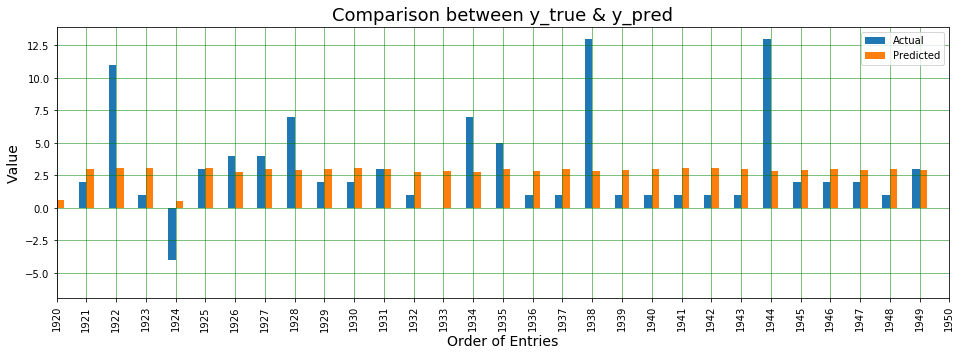

In [332]:
# create a df
df = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions})
df = df.reset_index(drop = True)

# plotting
plt.figure(figsize = (16, 4))
df.plot(kind = 'bar',figsize = (16,5))
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = 'green')
plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'black')
plt.xlim(1400,1430)
plt.title("Comparison between y_true & y_pred", fontsize = 18)
plt.ylabel("Value", fontsize = 14)
plt.xlabel("Order of Entries", fontsize = 14)

# take a look at part of the data
plt.xlim(1920,1950)

Text(0, 0.5, 'Predictions')

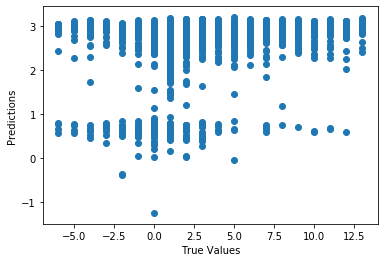

In [139]:
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [140]:
print("R-squared:", model.score(X_test, Y_test)) # low value

R-squared: 0.024614384673189327


In [141]:
rmse = 0
for i in range(len(predictions)):
    
    rmse += (list(Y_test)[i] - predictions[i]) ** 2
    
    rmse_out = np.sqrt(rmse / len(predictions))
    
print("RMSE:", rmse_out) # Pretty low

RMSE: 3.1906255142759106


In [142]:
model.intercept_

3.355518994093951

In [143]:
print("Coefficient Values")
print("overall_sent_score:", model.coef_[0])
print("controversiality:", model.coef_[1])
print("body_length:", model.coef_[2])

Coefficient Values
overall_sent_score: -0.7711052668422775
controversiality: -2.2835054224168094
body_length: -0.007888327217906


## Run general linear regression without splitting to get coefficients

In [144]:
import statsmodels.formula.api as sm  # import statsmodels 

- Regress the score of the comment on the length, it's overall sentiment score, and its controversialness.

In [145]:
results = sm.ols("score ~ body_length + overall_sent_score + controversiality", 
                 data = politics_out).fit()

- Low R-Squared Value --> statistical significance for all dependent variables.

In [290]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     158.9
Date:                Thu, 23 Apr 2020   Prob (F-statistic):          6.71e-102
Time:                        10:57:39   Log-Likelihood:                -55394.
No. Observations:               21461   AIC:                         1.108e+05
Df Residuals:                   21457   BIC:                         1.108e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.29

- Parameter Results: very similar to train/test split coefficients (6.1).

In [147]:
results.params  # very very similar to train/test split coefficients

Intercept                3.295924
controversiality[T.1]   -2.319194
body_length             -0.008282
overall_sent_score      -0.603923
dtype: float64

## Train regression model on TF-IDF matrix

- Re-define TF-IDF matrix

In [333]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, min_df = 10, 
                                   ngram_range=(1, 1), stop_words = "english")
X = tfidf_vectorizer.fit_transform(corpus)

X = X.toarray()
tfidf_df = pd.DataFrame(X)

- Add score variable

In [334]:
tfidf_df = tfidf_df.join(politics_data[["score", "body_length", "overall_sent_score", "controversiality"]])

In [335]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4100,4101,4102,4103,4104,4105,score,body_length,overall_sent_score,controversiality
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,9,0.468815,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12,10,0.399522,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,7,0.389751,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-6,6,0.390280,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17,6,0.345299,0


- Remove outliers, subset y variable, remove score variable.

In [336]:
# Find IQR
Q1 = tfidf_df["score"].quantile(0.25)
Q3 = tfidf_df["score"].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
tfidf_out = tfidf_df[tfidf_df["score"] < (Q3 + 1.5 * IQR)]
tfidf_out = tfidf_out[tfidf_out["score"] > (Q1 - 1.5 * IQR)]


# subset y variable
y2 = tfidf_out.score

# drop score
tfidf_out = tfidf_out.drop(columns = ["score"])

# Reset Index
tfidf_out = tfidf_out.reset_index()

In [337]:
tfidf_out.head()

,index,0,1,2,3,4,5,6,7,8,...,4099,4100,4101,4102,4103,4104,4105,body_length,overall_sent_score,controversiality
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.468815,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0.399522,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0.389751,0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.390280,0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,0.432123,0


- Train/test split

In [338]:
# split train and test data
X2_train, X2_test, Y2_train, Y2_test = train_test_split(tfidf_out, y2, 
                                                        test_size = 0.25, random_state = 1)

- Fit a new model

In [339]:
lm = linear_model.LinearRegression()
model2 = lm.fit(X2_train, Y2_train)
predictions2 = lm.predict(X2_test)

- **Produce plots of yhat vs. ytrue:** According to the plots below, the difference between y_pred and y_true is large sometimes but it is pretty close most of the time.
<br>

**Reference:** https://bit.ly/2RT2SRe

(1920, 1950)

<Figure size 1152x288 with 0 Axes>

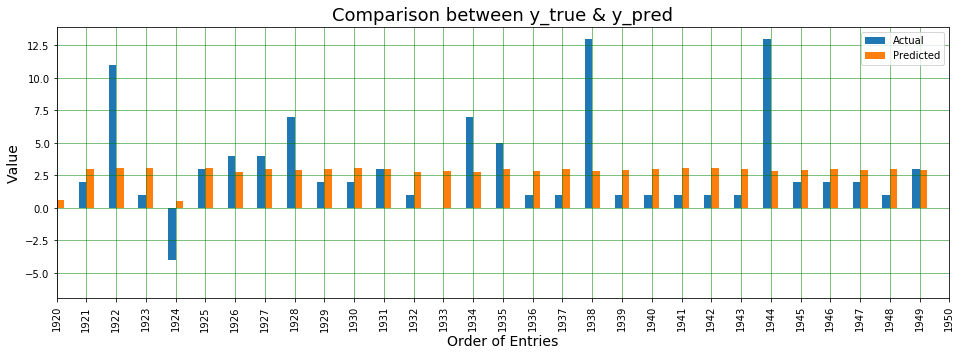

In [340]:
# create a df
df2 = pd.DataFrame({'Actual': Y2_test, 'Predicted': predictions2})
df2 = df.reset_index(drop = True)

# plotting
plt.figure(figsize = (16, 4))
df2.plot(kind = 'bar',figsize = (16,5))
plt.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = 'green')
plt.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'black')
plt.xlim(1400,1430)
plt.title("Comparison between y_true & y_pred", fontsize = 18)
plt.ylabel("Value", fontsize = 14)
plt.xlabel("Order of Entries", fontsize = 14)

# take a look at part of the data
plt.xlim(1920,1950)

Text(0, 0.5, 'Predictions')

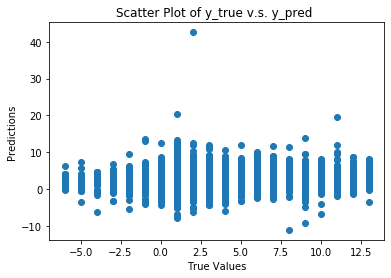

In [277]:
plt.scatter(Y2_test, predictions2)
plt.title("Scatter Plot of y_true v.s. y_pred")
plt.xlabel("True Values")
plt.ylabel("Predictions")

- Summary Stats... R-squared not accurate (and negative --> not accurate -->see help page) but RMSE is low.

In [157]:
print("R-squared:", model2.score(X2_test, Y2_test))

R-squared: -0.3442531730282339


In [158]:
rmse = 0
for i in range(len(predictions2)):
    
    rmse += (list(Y2_test)[i] - predictions2[i]) ** 2
    
    rmse_out = np.sqrt(rmse / len(predictions2))
    
print("RMSE:", rmse_out)

RMSE: 3.745658641619775


- Make a dataframe from the coefficient outputs.

In [159]:
betas = pd.DataFrame(model2.coef_[1:])
betas.columns = ["Betas"]

In [184]:
betas.head(10)

,Betas
0,-0.200438
1,1.276361
2,0.062117
3,3.030117
4,-0.700279
5,-0.813882
6,1.415927
7,5.907177
8,-0.846506
9,8.524779


- Sort term dictionary by the index that they were in for the TF-IDF matrix.
<br>

**Reference:** https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

In [161]:
terms_dict = {k: v for k, v in sorted(tfidf_vectorizer.vocabulary_.items(), 
                                      key = lambda item: item[1])}
terms = pd.DataFrame(list(terms_dict.keys()))

In [183]:
terms.head(10)

,0
0,abandoned
1,ability
2,able
3,abortion
4,abrams
5,absolute
6,absolutely
7,absurd
8,abuse
9,abused


- Join the dictionaries.

In [163]:
coefficients = betas.join(terms)
coefficients.columns = ["Betas", "Feature"]

- See which 1-gram words had highest/lowest coefficients. There seems to be no discernable pattern.

In [164]:
coefficients.sort_values(by = 'Betas', ascending = False).head(7)

,Betas,Feature
2655,78.391272,performed
2463,62.098451,notability
3416,62.098451,soundclips
2693,35.607651,placed
2020,26.326307,keywords
116,20.087543,alleviate
556,17.381032,cheated


In [165]:
coefficients.sort_values(by = "Betas", ascending = True).head(7)

,Betas,Feature
3558,-121.007879,subredditmessagecomposeto
1260,-32.885438,exclusive
681,-27.632830,completing
249,-22.158693,authorize
1096,-19.887569,drama
1415,-17.731639,flooding
1059,-17.497666,division


# `Topic Modeling`
<br>

- Create and apply a function trimming too long/possibily non-word. Remove words which contain more than 20 characters.

In [ ]:
# write a function
def vocab_trimmer(docs):
    
    words = docs.split()
    word_trim = [w for w in words if len(w) < 20 ]
    
    return(word_trim)

# apply the function for the body variable in politics_data
politics_data["body"] = politics_data["body"].apply(vocab_trimmer)

# make a corpus
corpus = list(politics_data["body"])

# briefly print the corpus
corpus[0:7]

## TF-IDF vectorizing

In [166]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, min_df = 10, 
                                   ngram_range=(1, 2), stop_words = "english")
X = tfidf_vectorizer.fit_transform(corpus)
tfidf_vocab = tfidf_vectorizer.get_feature_names()   # vocabulary list (terms)

X.toarray()   # term-freq matrix_At

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [167]:
np.shape(X.toarray())   # 25,000 documents * 5,920 vocabulary

(25000, 5877)

## NMF on TF-IDF matrix

In [168]:
### NMF

# function for returning output
def print_top_words(model, vocab_list, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([vocab_list[i] 
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        output = print(message)
    return(output)

# NMF results - 10 topics with top 20 words
nmf = NMF(n_components = 10).fit(X)
print_top_words(nmf, tfidf_vocab, n_top_words = 20)

Topic #0: violation rule automatically subredditmessagecomposeto question performed automatically action performed bot action contact moderator moderator subredditmessagecomposeto subredditmessagecomposeto automatically contact question concern performed report bot ban comment harm rule rule violation wishing deathphysical advocating wishing comment violation
Topic #1: people right republican know time want vote thing going need good make way democrat really point sure year mean let
Topic #2: submission removal regarding removal regarding question removal submission thank removed megathread feel free removal feel moderator regarding question removal free message thank participating question regarding message moderator participating message free
Topic #3: barr mueller said letter summary congress medium doj mueller said report testify thought inaccurate official memo mueller letter mueller report lied testimony coverage
Topic #4: like look look like sound sound like feel like feel barr 

# `KMeans Clustering`

- Import kmeans module

In [302]:
from sklearn.cluster import KMeans

- Subsetted data to test on

In [303]:
test = politics_data.sample(5000)
test_list = list(test["body"])

- Get TF-IDF and H Matrix (for clustering and topic output).

In [304]:
X = tfidf_vectorizer.fit_transform(corpus)
H = nmf.fit_transform(X)
vocab = tfidf_vectorizer.get_feature_names()

- Write a function to get top 10 words which are the nearset to the centroids.
<br>

**Reference:** http://brandonrose.org/clustering#Tf-idf-and-document-similarity

In [305]:
## Top n words for each cluster
def top_words_KM(cluster, n_top_words, vocab_list):
    
    # get centroids and arrange the indices of centroids
    order_centroids_index = cluster.cluster_centers_.argsort()[:,::-1]
    
    for i in range(cluster.n_clusters):
        print_wds = [vocab_list[index] for index in order_centroids_index[i,:n_top_words]]
        output = print("Cluster {}: {}".format(i, ', '.join(print_wds)))
    
    return(output)

In [306]:
KM = KMeans(n_clusters = 10, random_state = 1, max_iter = 100)
kmeans_label = KM.fit_predict(X).tolist()
top_words_KM(cluster = KM, n_top_words = 15, vocab_list = vocab)

Cluster 0: right, graham, shit, fucking, lindsey, lindsey graham, trump, fuck, like, thing, piece shit, know, piece, going, email
Cluster 1: submission, removal, regarding removal, regarding, removal submission, question, thank, removed, megathread, removal feel, free message, moderator regarding, question removal, thank participating, question regarding
Cluster 2: people, republican, vote, trump, like, think, want, democrat, thing, know, party, need, right, make, american
Cluster 3: violation, rule, shill troll, attack idea, general courteous, personal insult, troll accusation, accusation hate, advocating wishing, result permanent, permanent ban, subreddit civil, ban comment, violation result, speech advocating
Cluster 4: mueller, barr, letter, said, doj, report, summary, congress, mueller said, medium, mueller letter, say, investigation, testify, know
Cluster 5: trump, like, think, know, say, going, need, want, make, president, thing, way, really, mean, got
Cluster 6: barr, trump, li

- Get the counts of the cluster assignments.

In [307]:
from collections import Counter
Counter(kmeans_label) # one cluster has most of the comments (seems like the most general too)

Counter({7: 614,
         5: 14756,
         2: 2537,
         4: 1479,
         3: 469,
         9: 1070,
         6: 1399,
         1: 231,
         8: 840,
         0: 1605})

- Plot a histogram of the cluster assignments.

Text(0.5, 1.0, 'Cluster Scoring Distribution')

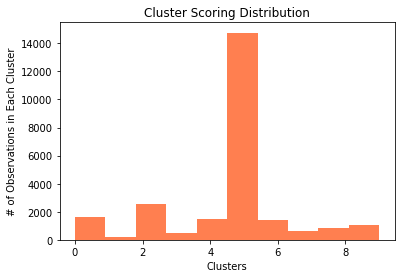

In [325]:
plt.hist(kmeans_label, color = "coral")
plt.xlabel("Clusters")
plt.ylabel("# of Observations in Each Cluster")
plt.title("Cluster Scoring Distribution")

- Plot a density plot of the cluster assignments.

Text(0, 0.5, 'Proportion in Each Cluster')

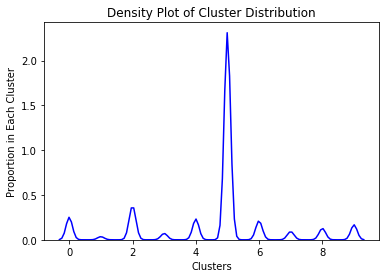

In [309]:
sns.distplot(kmeans_label, hist = False, color= "blue", bins = 1)
plt.title("Density Plot of Cluster Distribution")
plt.xlabel("Clusters")
plt.ylabel("Proportion in Each Cluster")

- Check text of comments to see if they are similar.

In [320]:
my_list = []
for i in range(len(kmeans_label)):
    if kmeans_label[i] == 5:
        my_list.append(i)
        
print(my_list[0:10])
print(my_list[145:155])
print(my_list[-10:-1])

[1, 4, 5, 7, 9, 11, 12, 14, 15, 20]
[242, 243, 246, 247, 248, 249, 252, 253, 254, 259]
[24982, 24984, 24985, 24987, 24990, 24992, 24993, 24994, 24996]


- Pick a few index numbers from directly above and replace in code below to see similar output. The clusters seem to line up.

In [324]:
print("1.", politics_data["body"][5])  

print("2", politics_data["body"][243])  

print("3",politics_data["body"][24992])

1. everything power make sure biden get nomination fall line doe primary coronation
2 nope nonstate function dignitary conducting diplomacy actual state function govt funded kind event actually considered government business reimbursed thus trump pr move buying hamberders shutdown save government intended save him billionaire money
3 well corporation democrat pocket case trump make cut


# `Classification`

## Two classes - sports subreddits
<br>

- We wanted to pick subreddits that were similar enough to be tough to train a model on but distinct enough to tell differences. Sports themes subreddits seemed to fit the model.

In [197]:
# Re-load original data
data = data

- Import packages

In [198]:
# classifying modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier

# sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

- Subset data

In [199]:
subs = ["nba", "nfl"]
test = data[data.subreddit.isin(subs)]

- Clean data

In [200]:
test["body"] = test["body"].apply(textCleaner)
test["body"] = test["body"].apply(textNormalization)
test["body"]

7                                          report water wet
12                              michael jackson popcorn gif
23        the reason anyone know jared dudley ben simmon...
31        would say year old buddy hield part king young...
55                                oh know going comment lol
                                ...                        
919444    mean put weight letter lawyer nfl gtfinally m ...
919445                   rip fedora man really getting good
919449    andy reid marv levy suffer lack super bowl alt...
919456    none change fact succeeded nfl point star play...
919486    mean reason season great last year oline stren...
Name: body, Length: 50000, dtype: object

- Define and run classifier function

In [201]:
def isNBA(string):
    x = 0
    if string == "nba":
        x += 1
    return(x)

test["category"] = test.subreddit.apply(isNBA)

In [203]:
test.head()

,subreddit,body,controversiality,score,category
7,nba,report water wet,0,9,1
12,nba,michael jackson popcorn gif,0,1,1
23,nba,the reason anyone know jared dudley ben simmon...,0,-5,1
31,nba,would say year old buddy hield part king young...,1,-2,1
55,nba,oh know going comment lol,0,1,1


- Make corpus for vectorization and y_true tags.

In [204]:
text = list(test["body"])
classifier = list(test["category"])

- Split and vectorize the data

In [205]:
data_train, data_test = train_test_split(text, train_size = 0.8, random_state = 5)
y_train, y_actual = train_test_split(classifier, train_size = 0.8, random_state = 5)

In [206]:
X_train = tfidf_vectorizer.fit_transform(data_train)
H_train = nmf.fit_transform(X_train)

- Fit Knn classfier

In [207]:
neigh = KNeighborsClassifier(n_neighbors = 4)
neigh.fit(H_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

- Generate predicted classes

In [208]:
X_test = tfidf_vectorizer.transform(data_test) # not fit
H_test = nmf.transform(X_test) # not fit

In [209]:
y_pred = neigh.predict(H_test)

- Get classifier scores. This model is overall a pretty accurate model.

In [210]:
print("F1 Score:", f1_score(y_actual, y_pred))
print("Precision Score:", precision_score(y_actual, y_pred))
print("Recall Score:", recall_score(y_actual, y_pred))

F1 Score: 0.6695862625331336
Precision Score: 0.7911220043572985
Recall Score: 0.5804195804195804


In [211]:
target_names = ["NBA", "NFL"]
print(classification_report(y_actual, y_pred, target_names = target_names))

              precision    recall  f1-score   support

         NBA       0.67      0.85      0.75      4995
         NFL       0.79      0.58      0.67      5005

    accuracy                           0.71     10000
   macro avg       0.73      0.71      0.71     10000
weighted avg       0.73      0.71      0.71     10000



## Four classes - More sports
<br>
- According to the classification results below, it is tougher to train more classes.

In [212]:
data = data

In [213]:
subs = ["nba", "nfl", "hockey", "soccer"]
test = data[data.subreddit.isin(subs)]

In [214]:
test["body"] = test["body"].apply(textCleaner)
test["body"] = test["body"].apply(textNormalization)
test["body"]

7                                          report water wet
12                              michael jackson popcorn gif
21                           google chrome suck donkey dick
23        the reason anyone know jared dudley ben simmon...
31        would say year old buddy hield part king young...
                                ...                        
919444    mean put weight letter lawyer nfl gtfinally m ...
919445                   rip fedora man really getting good
919449    andy reid marv levy suffer lack super bowl alt...
919456    none change fact succeeded nfl point star play...
919486    mean reason season great last year oline stren...
Name: body, Length: 100000, dtype: object

In [215]:
def isNBA(string):
    x = 0
    if string == "nba":
        x = 0
    elif string == "nfl":
        x = 1
    elif string == "hockey":
        x = 2
    elif string == "soccer":
        x = 3
    return(x)

test["category"] = test.subreddit.apply(isNBA)

In [216]:
test

,subreddit,body,controversiality,score,category
7,nba,report water wet,0,9,0
12,nba,michael jackson popcorn gif,0,1,0
21,hockey,google chrome suck donkey dick,0,2,2
23,nba,the reason anyone know jared dudley ben simmon...,0,-5,0
31,nba,would say year old buddy hield part king young...,1,-2,0
...,...,...,...,...,...
919444,nfl,mean put weight letter lawyer nfl gtfinally m ...,0,0,1
919445,nfl,rip fedora man really getting good,0,4,1
919449,nfl,andy reid marv levy suffer lack super bowl alt...,0,7,1
919456,nfl,none change fact succeeded nfl point star play...,0,4,1


In [217]:
text = list(test["body"])
classifier = list(test["category"])

In [218]:
data_train, data_test = train_test_split(text, train_size = 0.8, random_state = 5)
y_train, y_actual = train_test_split(classifier, train_size = 0.8, random_state = 5)

In [219]:
X_train = tfidf_vectorizer.fit_transform(data_train)
H_train = nmf.fit_transform(X_train)

In [220]:
neigh = KNeighborsClassifier(n_neighbors = 4)
neigh.fit(H_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [221]:
X_test = tfidf_vectorizer.transform(data_test) # not fit
H_test = nmf.transform(X_test) # not fit

In [222]:
y_pred = neigh.predict(H_test)

In [223]:
f1_score(y_actual, y_pred, average = "weighted")

0.3836387209725444

In [224]:
precision_score(y_actual, y_pred, average = "weighted")

0.3886078659789782

In [225]:
recall_score(y_actual, y_pred, average = "weighted")

0.38765

- The output gives a less accurate model, but still not that bad.

In [226]:
target_names = ["NBA", "NFL", "Hockey", "Soccer"]
print(classification_report(y_actual, y_pred, target_names = target_names))

              precision    recall  f1-score   support

         NBA       0.41      0.51      0.46      5003
         NFL       0.36      0.42      0.39      4921
      Hockey       0.35      0.29      0.32      5011
      Soccer       0.43      0.33      0.37      5065

    accuracy                           0.39     20000
   macro avg       0.39      0.39      0.38     20000
weighted avg       0.39      0.39      0.38     20000



# `Appendix`

## Bindary Logistic Regression
<br>

- As we can see from the counts & graph below, the percentage of controversiality is 96.776, and the percentage of no controversiality is 3.22399. The controversiality is unbalanced.
<br>

**Reference** https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [243]:
politics_data["controversiality"].value_counts()[1]

806

In [244]:
# see the counts of controversiality
print("Value counts of controversiality:")
print(politics_data["controversiality"].value_counts())

Value counts of controversiality:
0    24194
1      806
Name: controversiality, dtype: int64


- If we look at the mean of score and sentiment scores groupby controversiality, the average score of up reddits minus down reddits has discrepancy (2.9 v.s. 0.58). However, the mean in all sentiment scores as well as overall sentiment score are all pretty close in between. Even the overall score has 0.01 higher in controversiality then no controversiality.

In [245]:
politics_out.groupby("controversiality").mean()

,index,score,body_length,Positive_Score,Negative_Score,net_score,slang_score,anew_score,vader_score,overall_sent_score
controversiality,,,,,,,,,,
0,12485.650826,2.908529,18.535642,0.108551,0.106273,0.501139,0.472363,0.070580,0.505058,0.387285
1,12918.679470,0.582781,18.998675,0.108177,0.106746,0.500716,0.472868,0.071179,0.522387,0.391787


- Implement the model. The p-values are small (< 0.05).

In [255]:
import statsmodels.api as sm
# subset y variable
x = politics_out[["overall_sent_score", "score"]]
y = politics_out.controversiality

# Logit model
logit_model = sm.Logit(y, x)
result = logit_model.fit()

# ------------- print result -------------
# p-value < 0.05 (both score & overall_sent_score)
result.summary2()

Optimization terminated successfully.
         Current function value: 0.147881
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:                Logit            Pseudo R-squared: 0.029     
Dependent Variable:   controversiality AIC:              6351.3343 
Date:                 2020-04-23 04:58 BIC:              6367.2822 
No. Observations:     21461            Log-Likelihood:   -3173.7   
Df Model:             1                LL-Null:          -3268.8   
Df Residuals:         21459            LLR p-value:      2.9149e-43
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       8.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
overall_sent_score -7.1376   0.1050 -67.9966 0.0000 -7.3433 -6.9319
score              -0.3505   0.0152 -23.0740 0.0000 -0.3803 -0.3208
===================================================================

"""

- Continually try on Logistic Regression Model Fitting.

In [256]:
from sklearn import linear_model
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.25, random_state = 1)
lm = linear_model.LogisticRegression()
model = lm.fit(X_train, Y_train)
predictions = lm.predict(X_test)

# ------------- print result -------------
print("Intercept:", model.intercept_)
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Intercept: [ -7.69446842  -5.76404902  -4.89978361  -5.11096805  -3.74612598
  -3.54537763  -2.3821199    0.60505876  -1.40963169  -2.33395375
  -3.11511531  -3.5133533   -3.98212319  -4.42548451  -5.30640502
  -6.13031765  -6.5206707   -7.84194941  -9.34061325 -13.52020389]
RMSE: 2.80211437127095


- **Accuracy (R-squared)**: The accuracy of logistic regression classifier on test set is 0.96 (very high).

In [257]:
print("R-squared:", model.score(X_test, y_test))

R-squared: 0.03410361535594484


- **Confusion Matrix**: The result gives that we have [5168 + 0] correct predictions and [198 + 0] incorrect predictions.

In [258]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)

[[   0 3963  501  306   77   49  110   25   17  120]
 [   0  183    4    5    1    0    4    0    0    1]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


**Precision, recall, F-measure and support**
<br>

The precision not to label classifier positive if it's negative. The recall helps to find all positive samples, in this data result, we have most non-controversiality samples. Lastly, the f1-score gives an overall mean to evaluate precision and recall. The support returns the number of occurrences of each class in y_test. 
<br>

According to the report below and the unbalanved controversiality rate, the precision and recall are both high (precision = 96%, recall = 100%), though the f1-score = 98% is almost the best. I believe this data is overfitting. Of the entire dataset, 98% reviews are non-controversiality.

In [253]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5168
           1       0.04      0.92      0.08       198
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0

    accuracy                           0.03      5366
   macro avg       0.00      0.09      0.01      5366
weighted avg       0.00      0.03      0.00      5366



**ROC Curve**

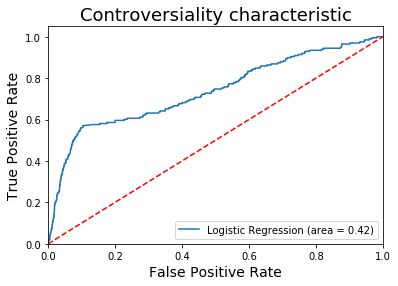

In [254]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, lm.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Controversiality characteristic', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.legend(loc = "lower right")
plt.savefig('Log_ROC')
plt.show()

### /Additional Work/ 
- We tried to create a visual graph of the clusters; however, this proved to be too difficult. To do this, we found that we needed to convert each document to a 2D form so it could be plotted on a flat plane. The computing power to do this on the entire dataset and produce coherant output was very difficult. The output graph below was with 5,000 of the 25,000 observations, and the online source we were trying to work through was difficult to apply to our project. We ultimately felt it was best to leave it out.

## Multidimensional Scaling
<br>

- Using multidimensional scaling to convert the dist matrix into a 2-dimensional array.
<br>

**Reference:** http://brandonrose.org/clustering#Tf-idf-and-document-similarity*

- Get cosine distance

In [227]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)

- Import packages

In [228]:
import matplotlib as mpl
from sklearn.manifold import MDS

In [229]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
MDS()
mds = MDS(n_components = 2, dissimilarity = "precomputed", random_state = 1, max_iter = 100)

- The transform function below for mds() takes a very very long while running through it.

In [347]:
# [!] takes a while
pos = mds.fit_transform(dist)   # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [306]:
# create a dataframe
cluster_df = pd.DataFrame(dict(x = xs, y = ys, 
                               label = kmeans_label, 
                               score = list(test["score"])))   # should be title = titles
# group by clusters
groups = cluster_df.groupby('label')

In [230]:
# set up colors per clusters using a dict
cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange', 5: 'brown'}

#set up cluster names using a dict
cluster_names = {0: 'republican, Trump, democrat', 
                 1: 'justice, Mueller report, congress', 
                 2: 'violation, harm', 
                 3: 'thoughts, feelings', 
                 4: 'say, Trump, action',
                 5: 'submission, removal'}

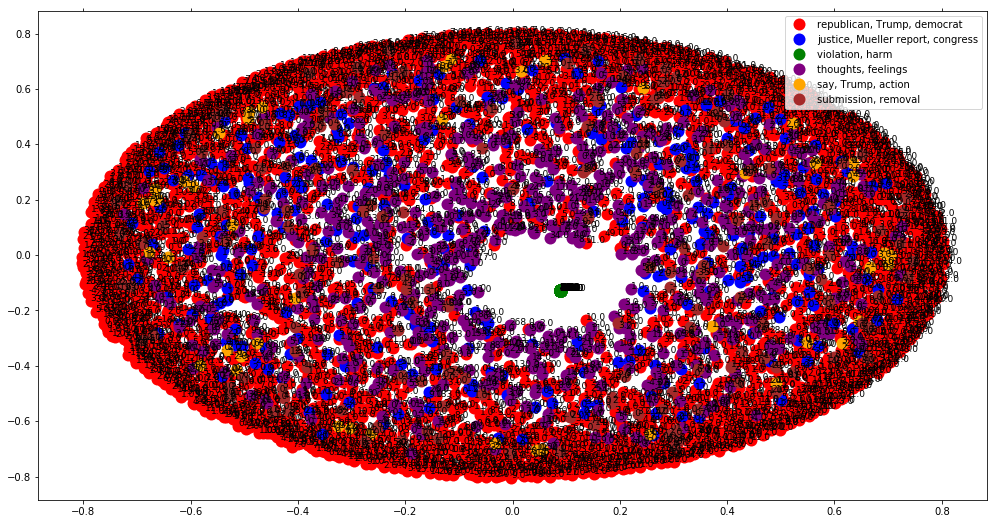

In [308]:
# set output plot size
fig, ax = plt.subplots(figsize = (17, 9)) # set size
ax.margins(0.05) 

# iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker = 'o', linestyle = '', ms = 12, 
            label = cluster_names[name], color = cluster_colors[name], 
            mec = 'none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis = 'x',          # changes apply to the x-axis
        which = 'both',      # both major and minor ticks are affected
        bottom = 'off',      # ticks along the bottom edge are off
        top = 'off',         # ticks along the top edge are off
        labelbottom = 'off')
    ax.tick_params(\
        axis = 'y',         # changes apply to the y-axis
        which = 'both',      # both major and minor ticks are affected
        left = 'off',      # ticks along the bottom edge are off
        top = 'off',         # ticks along the top edge are off
        labelleft = 'off')
    
ax.legend(numpoints = 1) 

# add labels
for i in range(len(cluster_df)):
    ax.text(cluster_df.iloc[i]['x'], 
            cluster_df.iloc[i]['y'], 
            cluster_df.iloc[i]['score'], size = 9)
    
plt.show() #show the plot